In [1]:
# N_simulation
from __future__ import division
import numpy as np
# from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import interpolate 
import matplotlib.pyplot as plt
import pandas as pd # to read excel
import datetime
from datetime import date
import datetime
from myfunctions_water_authority import *
%matplotlib inline

In [2]:
# Functions for optimization (i.e producing random parametric combination)
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol

In [5]:
x1 = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = x1.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

n_reactors = 1

z = 0.085

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


In [6]:
# Import of IMS I and T data
dfI = pd.read_csv('../data/ims_data_2020_June_I.csv',encoding= 'unicode_escape',header=None)
dfT = pd.read_csv('../data/ims_data_2020_June_T.csv',encoding= 'unicode_escape',header=None)

In [7]:
IV1, TV1,IV1_average,TV1_average = [],[],[],[]
for vali,valT in zip(dfI.iloc[1:1010:1][4],dfT.iloc[1:1010:1][3]):
    IV1.append(float(vali))
    TV1.append(float(valT))
print(len(IV1))
print(len(TV1))
for i in range(1,len(IV1),6):
    IV1_average.append(0.1*0.43*np.mean(IV1[i-1:i+6:1])) # 0.1 shading factor and 0.43 PAR factor
    #IV1_average.append(0.1*0.43*np.mean(IV1[i-1:i+6:1]))
    TV1_average.append(np.mean(TV1[i-1:i+6:1]))
print(len(TV1_average))
print(len(IV1_average))
    
IV2, TV2,IV2_average,TV2_average = [],[],[],[]
for vali,valT in zip(dfI.iloc[1010:1904:1][4],dfT.iloc[1010:1904:1][3]):
    IV2.append(float(vali))
    TV2.append(float(valT))
print(len(IV2))
print(len(TV2))
for i in range(1,len(IV2),6):
    IV2_average.append(0.1*0.43*np.mean(IV2[i-1:i+6:1])) # 0.1 shading factor and 0.43 PAR factor
    #IV2_average.append(0.5*0.43*np.mean(IV2[i-1:i+6:1]))
    TV2_average.append(np.mean(TV2[i-1:i+6:1]))
print(len(TV2_average))
print(len(IV2_average))

1009
1009
168
168
894
894
149
149


In [8]:
# Lists of initial and boundary conditions and empiric results for returns 1-2:
hour2i = int(7*24)+5

t0_all = [0, hour2i]
tf_all = [int(7*24), hour2i + int(6*24-5)]
mi_all = [[1,1,2,2,1,1,2,2,1,1,2,2],[2,2,2,2,2,2,3,3,2,2,3,3]]
mf_real = [[1.3,2.1,4,3,3.8,4.5,7.8,8.1,3.7,3.5,6.9,5.3],[3,2.6,5,4.6,4.4,5.7,5.7,5.8,5.1,4.7,6.55,6.9]]
S_all = [[6, 6, 6, 6, 24, 24, 24, 24, 29, 29, 29, 29],[6, 6, 40, 40, 22.5, 22.5, 22.5, 22.5, 17.5, 17.5,17.5,17.5]]
d_all = [[0,0,0,0,1,1,1,1,2,2,2,2],[0,0,0,0,1,1,1,1,0.5,0.5,0.5,0.5]]
Nint0_all = [[3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01,3.01],[4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09,4.09]]
Nintf_exps = [[2,3,4,5,7-1,8-1,9-1,10-1,12-2,13-2,14-2,15-2],[2,3,4,5,0,8-1,9-1,10-1,12-2,13-2,14-2,15-2]]
Nintf_real = [[3.12,2.31,2.47,2.82,2.35,2.08,1.56,1.59,2.02,1.86,1.43,1.92],[2.94,3.24,2.76,2.56,0,2.17,2.85,2.33,2.92,2.21,2.76,2.38]]

#functions = [Reading_val, Reading_val_IMS] ###
TV_average = [TV1_average, TV2_average]
IV_average = [IV1_average, IV2_average]
xlabels_all = [['8 June', '11 June','15 June'],['15 June','18 June', '21 June']]
l_all = [[['Brine\n6 PSU','  1:1\n24 PSU','  1:2\n29 PSU'],['Brine\n6 PSU','  1:1\n24 PSU','  1:2\n29 PSU']],[['Brine\n6 PSU','Brine+Salt\n  40 PSU','  1:1\n22.5 PSU','  1:0.5\n17.5 PSU'],['  1:1\n22.5 PSU','  1:0.5\n17.5 PSU']]]

In [9]:
# optimized parameters: bounds
#'µmax',
problem = {
    'num_vars': 15,
    'names': ['λ20','Nintmax','Nintcrit','Nextlosses','Ks','Vmax','KI','K0','Ka','Smin','Sopt','Smax','Topt','Tmax','n'],
    'bounds': [[0.001,0.005],
               [4,5],
               [0.7,3.2],
               [0.001,0.02],
               [10,30],
               [50,250],
               [15, 150],
               [0.1,3],
               [0.01,0.2],
               [0,10],
               [15,35],
               [40,50],
               [15, 25],
               [31,37],
               [1,6]]
}

print(problem)

{'num_vars': 15, 'names': ['λ20', 'Nintmax', 'Nintcrit', 'Nextlosses', 'Ks', 'Vmax', 'KI', 'K0', 'Ka', 'Smin', 'Sopt', 'Smax', 'Topt', 'Tmax', 'n'], 'bounds': [[0.001, 0.005], [4, 5], [0.7, 3.2], [0.001, 0.02], [10, 30], [50, 250], [15, 150], [0.1, 3], [0.01, 0.2], [0, 10], [15, 35], [40, 50], [15, 25], [31, 37], [1, 6]]}


In [10]:
# number of examined values per parameter - 10
param_values = saltelli.sample(problem, 500)
print(param_values.shape)

C:\Users\alex\miniconda3\envs\meiron\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (500) is equal to `2^n`.
        
  warnings.warn(msg)


(16000, 15)


In [11]:
len(problem['names'])

15

In [12]:
# growth and N dynamics figures (based on IMS data) 

Y1 = np.zeros([param_values.shape[0]])
Y2 = np.zeros([param_values.shape[0]])

evaluate_model1 = []
evaluate_model2 = []



returns = [1, 2]

w = 0

for p, X in enumerate(param_values):

    miu = 0.03
    lossess20 = X[0]
    Nintmax = X[1]
    Nintcrit = X[2]
    dNextoutdt = X[3]
    Ks = X[4]
    Vmax = X[5]
    KI = X[6]
    K0 = X[7]
    Ka = X[8]
    Smin = X[9]
    Sopt = X[10]
    Smax = X[11]
    Topt = X[12]
    Tmax = X[13]
    n = X[14]


    # growth and N dynamics figures (based on IMS data) 
    #miu = 0.04
    DATA = []
    Errors, RMSRE_m = [], []
    Errors, RMSRE_Nint = [], []
    RMSRE_m_all, RMSRE_Nint_all = [],[]
    returns = [1, 2]

    # model simulation
    for k in returns:
        Square_Errors_m = []
        Square_Errors_Nint = []

        t0 = t0_all[k-1]
        t = list(range(t0,tf_all[k-1]))

        # T Data 
        TV_reduced = TV_average[k-1][0:len(t)]
        f1 = interpolate.interp1d(t, TV_reduced,kind = 'linear')

        # I Data
        IV_reduced = IV_average[k-1][0:len(t)]
        f0 = interpolate.interp1d(t, IV_reduced,kind = 'linear')

        xlabels = xlabels_all[k-1]

        for j in range(len(mi_all[k-1])):
            #print('j = ' + str(j))

            # calculate and plot model results for each initial condition (runs only on odd numbers, to evoid dubble work)
            if j % 2 == 0:
                NEXT, NINT, M, T = [],[],[],[]

                line = '--'
                S = S_all[k-1][j]
                m0 = 0.15 * mi_all[k-1][j]
                Nint0 = Nint0_all[k-1][j]
                d = d_all[k-1][j]
                Next0 = Next00 / (1 + d)
                x0 = n_reactors*[Next0, Nint0, m0]

                # setup initial conditions identical for all reactors
                args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,S,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
                        teta,Sopt,Smin,Smax,f1,f0,dilution,n,umol_to_percent_DW,dNextoutdt)

                # solve the ODEs using the new syntax
                sol = solve_ivp(Bottles_IMS, [t[0], t[-1]], x0, args=args, t_eval = t)

                # take the solution of the state variables:
                NEXT.append(sol.y[0,:]/1000*62)
                NINT.append(sol.y[1,:])
                M.append(sol.y[2,:])

                T.append(sol.t)

                t = T[0]

            data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
            DATA.append(data)

            # Mark real Nint data as a star

            #print('exp: ' + str(j+2))
            #print('Real Nint is: ' + str(Nintf_exps[k-1][j]))
            #if Nintf_exps[k-1][j] == j + 2:
            #    print('exp: ' + str(j + 2))
            #    ax[1,r].plot(t[-1],Nintf_real[k-1][j],'*',markersize = 6,color=color)

            # calculate errors

            # m error

            final_m = round(M[-1][-1],2)
            #print(final_m)
            measured_m = round(mf_real[k-1][j],2)
            #print(measured_m)
            error_m = round((measured_m - final_m/0.15) / measured_m,3)
            square_error_m = error_m**2
            #print(square_error_m)
            Square_Errors_m.append(square_error_m)
            RMSRE_m_all.append((square_error_m)) # Square_Errors_m and RMSRE_m_all are the same in the mean while


            # Nint error

            final_Nint = round(NINT [-1][-1],2)

            if Nintf_exps[k-1][j] == j + 2: # ignoring samples without Nintf measurement
                measured_Nint = round(Nintf_real[k-1][j],2)
                error_Nint = round((measured_Nint - final_Nint) / measured_Nint,3)
                square_error_Nint = error_Nint**2
                #print(square_error_Nint)
                Square_Errors_Nint.append(square_error_Nint)
                RMSRE_Nint_all.append((square_error_Nint))

            plt.tight_layout()


        #RMSRE_m.append((np.mean(Square_Errors_m))**0.5)

        #RMSRE_m_all.append((Square_Errors_m))

        #RMSRE_Nint.append((np.mean(Square_Errors_Nint))**0.5)

        Square_Errors_m,Square_Errors_Nint = [],[]

        ...
        ...

    RMSREm = (np.mean(RMSRE_m_all))**0.5
    #print(RMSREm)
    #print(len(RMSRE_m_all))
    #print(RMSRE_m_all)
    #print(RMSREm)
    RMSRENint = (np.mean(RMSRE_Nint_all))**0.5
    #print(RMSRENint)
    #print(len(RMSRE_Nint_all))
    #print(RMSRENint)

    evaluate_model1.append(RMSREm)
    evaluate_model2.append(RMSRENint)

    Y1[p] = round(evaluate_model1[-1],3)
    Y2[p] = round(evaluate_model2[-1],3)

    print(w)
    w = w+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


In [ ]:
print(min(Y1))
print(np.mean(Y1))
print(np.std(Y1))
print(np.median(Y1))
print(max(Y1))

0.145
0.404575875
0.10607570229786073
0.415
1.014


In [ ]:
Si1 = sobol.analyze(problem, Y1,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
λ20 0.000000 0.000000 0.000000 0.000000
Nintmax -0.004139 0.005827 0.003186 0.001075
Nintcrit -0.000478 0.003168 0.000749 0.000376
Nextlosses -0.003639 0.007487 0.004139 0.001132
Ks -0.004122 0.005231 0.002661 0.001619
Vmax 0.000545 0.009253 0.004628 0.001211
KI 0.273558 0.101388 0.593795 0.135546
K0 0.006891 0.014125 0.012946 0.002910
Ka -0.001149 0.002512 0.001264 0.000864
Smin 0.212145 0.068021 0.294105 0.053983
Sopt 0.000103 0.026113 0.040214 0.011925
Smax 0.006676 0.014076 0.010606 0.002135
Topt 0.187515 0.079262 0.468321 0.109261
Tmax 0.002423 0.032926 0.081338 0.017834
n 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
λ20 Nintmax 0.000000 0.000000
λ20 Nintcrit 0.000000 0.000000
λ20 Nextlosses 0.000000 0.000000
λ20 Ks 0.000000 0.000000
λ20 Vmax 0.000000 0.000000
λ20 KI 0.000000 0.000000
λ20 K0 0.000000 0.000000
λ20 Ka 0.000000 0.000000
λ20 Smin 0.000000 0.000000
λ20 Sopt 0.000000 0.000000
λ20 Smax 0.000000 0.000000
λ20 Topt 

In [ ]:
print(min(Y2))
print(np.mean(Y2))
print(np.std(Y2))
print(np.median(Y2))
print(max(Y2))

0.199
0.6703889375
0.20961128289078595
0.671
5.083


In [ ]:
Y3 = Y1+Y2
print(min(Y1))
print(min(Y2))
print(min(Y3))

0.145
0.199
0.41000000000000003


In [ ]:
Si2 = sobol.analyze(problem, Y2,print_to_console=True)

Parameter S1 S1_conf ST ST_conf
λ20 0.000000 0.000000 0.000000 0.000000
Nintmax 0.129156 0.045456 0.139808 0.024086
Nintcrit 0.000741 0.001397 0.000100 0.000032
Nextlosses 0.200783 0.059029 0.197935 0.033599
Ks -0.004478 0.005898 0.001482 0.001676
Vmax 0.046667 0.038662 0.079693 0.062095
KI 0.276580 0.119367 0.505337 0.460583
K0 0.005169 0.010018 0.005999 0.000978
Ka -0.000456 0.001302 0.000095 0.000031
Smin 0.014375 0.036887 0.084498 0.038699
Sopt 0.017918 0.038525 0.061605 0.079644
Smax 0.001042 0.002729 0.000685 0.000143
Topt 0.186858 0.061500 0.236383 0.037331
Tmax 0.032257 0.027896 0.043162 0.007839
n 0.000000 0.000000 0.000000 0.000000

Parameter_1 Parameter_2 S2 S2_conf
λ20 Nintmax 0.000000 0.000000
λ20 Nintcrit 0.000000 0.000000
λ20 Nextlosses 0.000000 0.000000
λ20 Ks 0.000000 0.000000
λ20 Vmax 0.000000 0.000000
λ20 KI 0.000000 0.000000
λ20 K0 0.000000 0.000000
λ20 Ka 0.000000 0.000000
λ20 Smin 0.000000 0.000000
λ20 Sopt 0.000000 0.000000
λ20 Smax 0.000000 0.000000
λ20 Topt 0.0

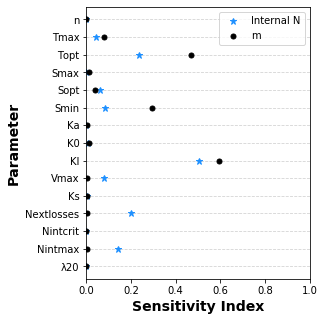

In [ ]:
fig,ST2 = plt.subplots(1,1,sharex=True,figsize=(4,5))
#ST2.plot(Si3['ST'],problem['names'],'s',markersize=5,color='dimgray')
ST2.plot(Si2['ST'],problem['names'],'*',markersize=7,color='dodgerblue')
ST2.plot(Si1['ST'],problem['names'],'.',markersize=10,color='black')


ST2.set_xlabel('Sensitivity Index',fontsize=14, weight="bold")
ST2.set_ylabel('Parameter',fontsize=14, weight="bold")
ST2.set_xlim([0, 1])
ST2.set_axisbelow(True)
ST2.yaxis.grid(color='lightgray', linestyle='dashed')
ST2.legend(['Internal N','m'])


name = 'Brine Sensitivity.png' 
fig.savefig(fname=name, dpi=600)

In [ ]:
a = []
for i in Si2['S2']:
    for j in i:
        if np.isnan(j)!= True:
            a.append(j)

for i in Si2['S1']:
    if np.isnan(i)!= True:
        a.append(i)

for i in Si2['ST']:
    if np.isnan(i)!= True:
        a.append(i)
            
print(np.sum(a))
#np.sum(Si2['S1'])

2.2705213303382856


In [ ]:
Y3 = Y1 + Y2
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 5) & (Y2[i] < 5):
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    
    # Combined (Y3)
    
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    #ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sqC = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')
    
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))],['$R^{2}$ = ' + str(round(r_sqC,2))]],fontsize = 14,loc = 'upper left',markerscale = 2.5)

    
plt.tight_layout()
plt.show()

name = 'Brine Full Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

NameError: name 'Y1' is not defined

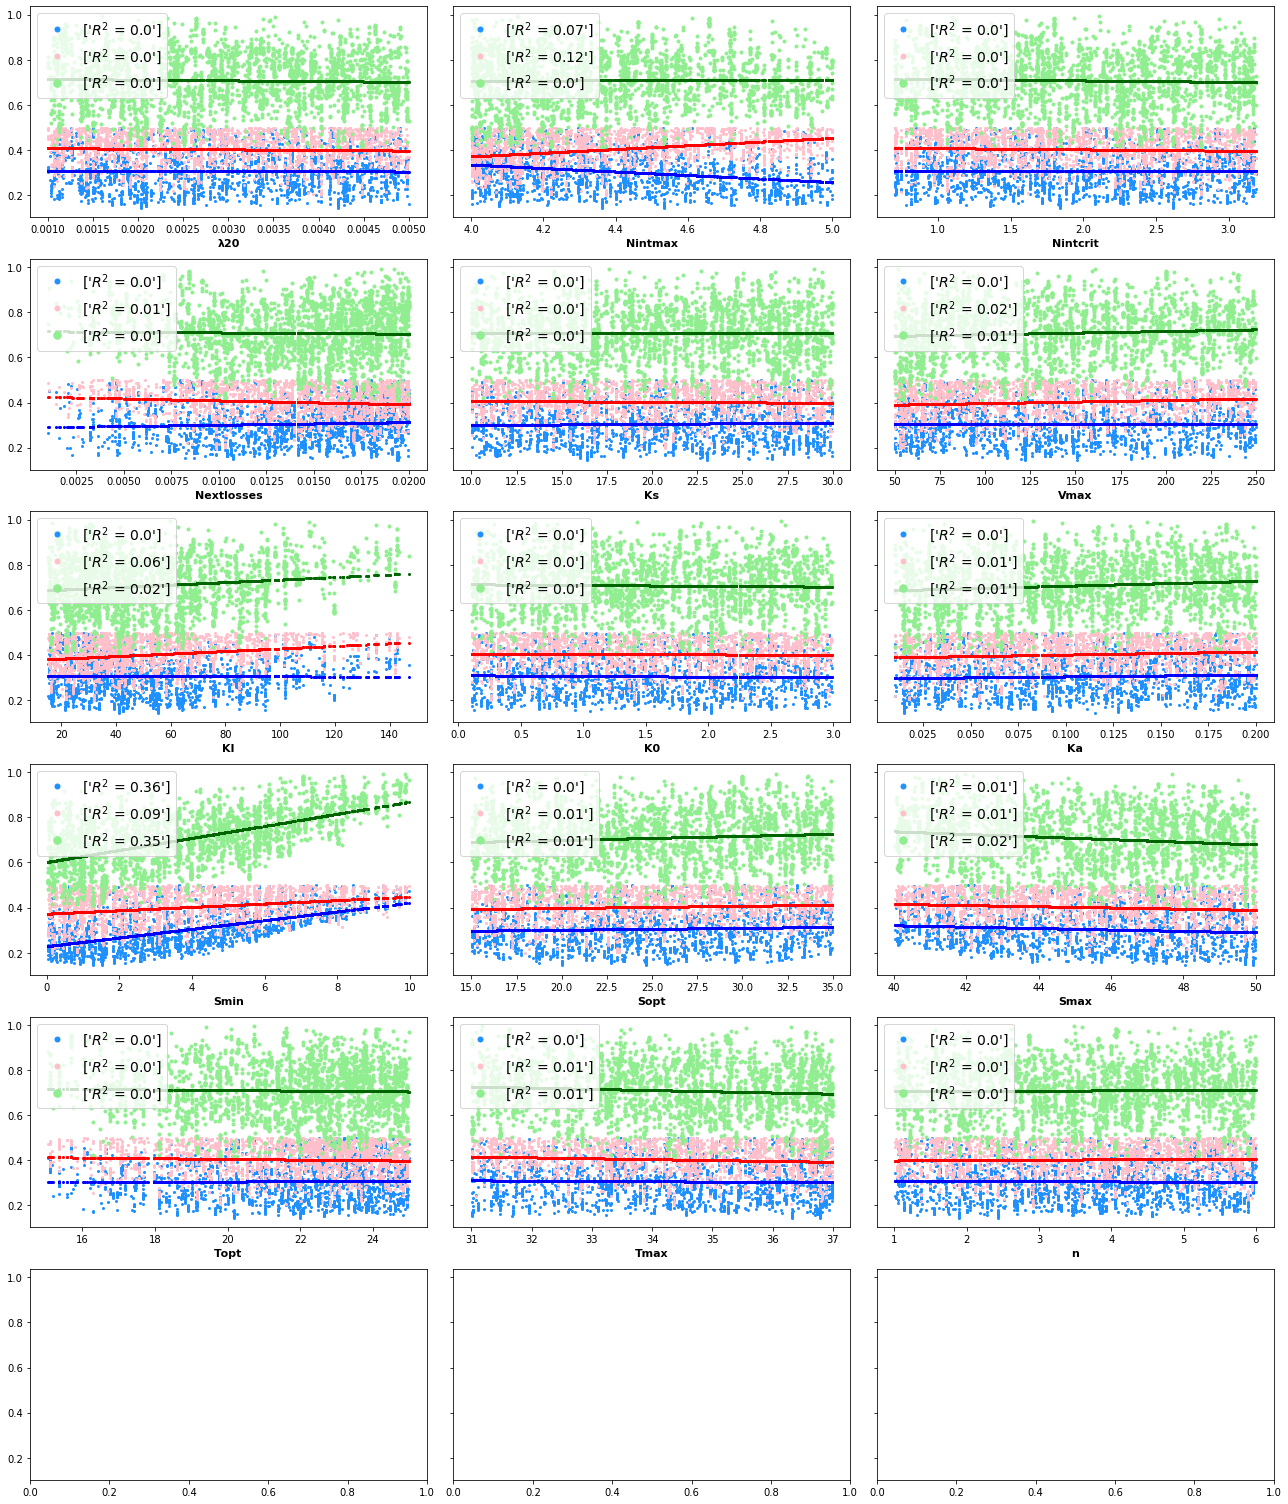

In [ ]:
Y3 = Y1 + Y2
from sklearn.linear_model import LinearRegression
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 0.5) & (Y2[i] < 0.5):
        Best_index.append(i)
        
b = param_values[Best_index].T

fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=4,color = 'dodgerblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=4,color = 'pink')
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    
    
    # regression line and coefficient:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], NN*b[j] + cc,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    
    # Combined (Y3)
    
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    #ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sqC = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    #ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')
    
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))],['$R^{2}$ = ' + str(round(r_sqC,2))]],fontsize = 14,loc = 'upper left',markerscale = 2.5)

    
plt.tight_layout()
plt.show()

name = 'Brine Error plots reduced.png' 
    
fig.savefig(fname=name, dpi=600)

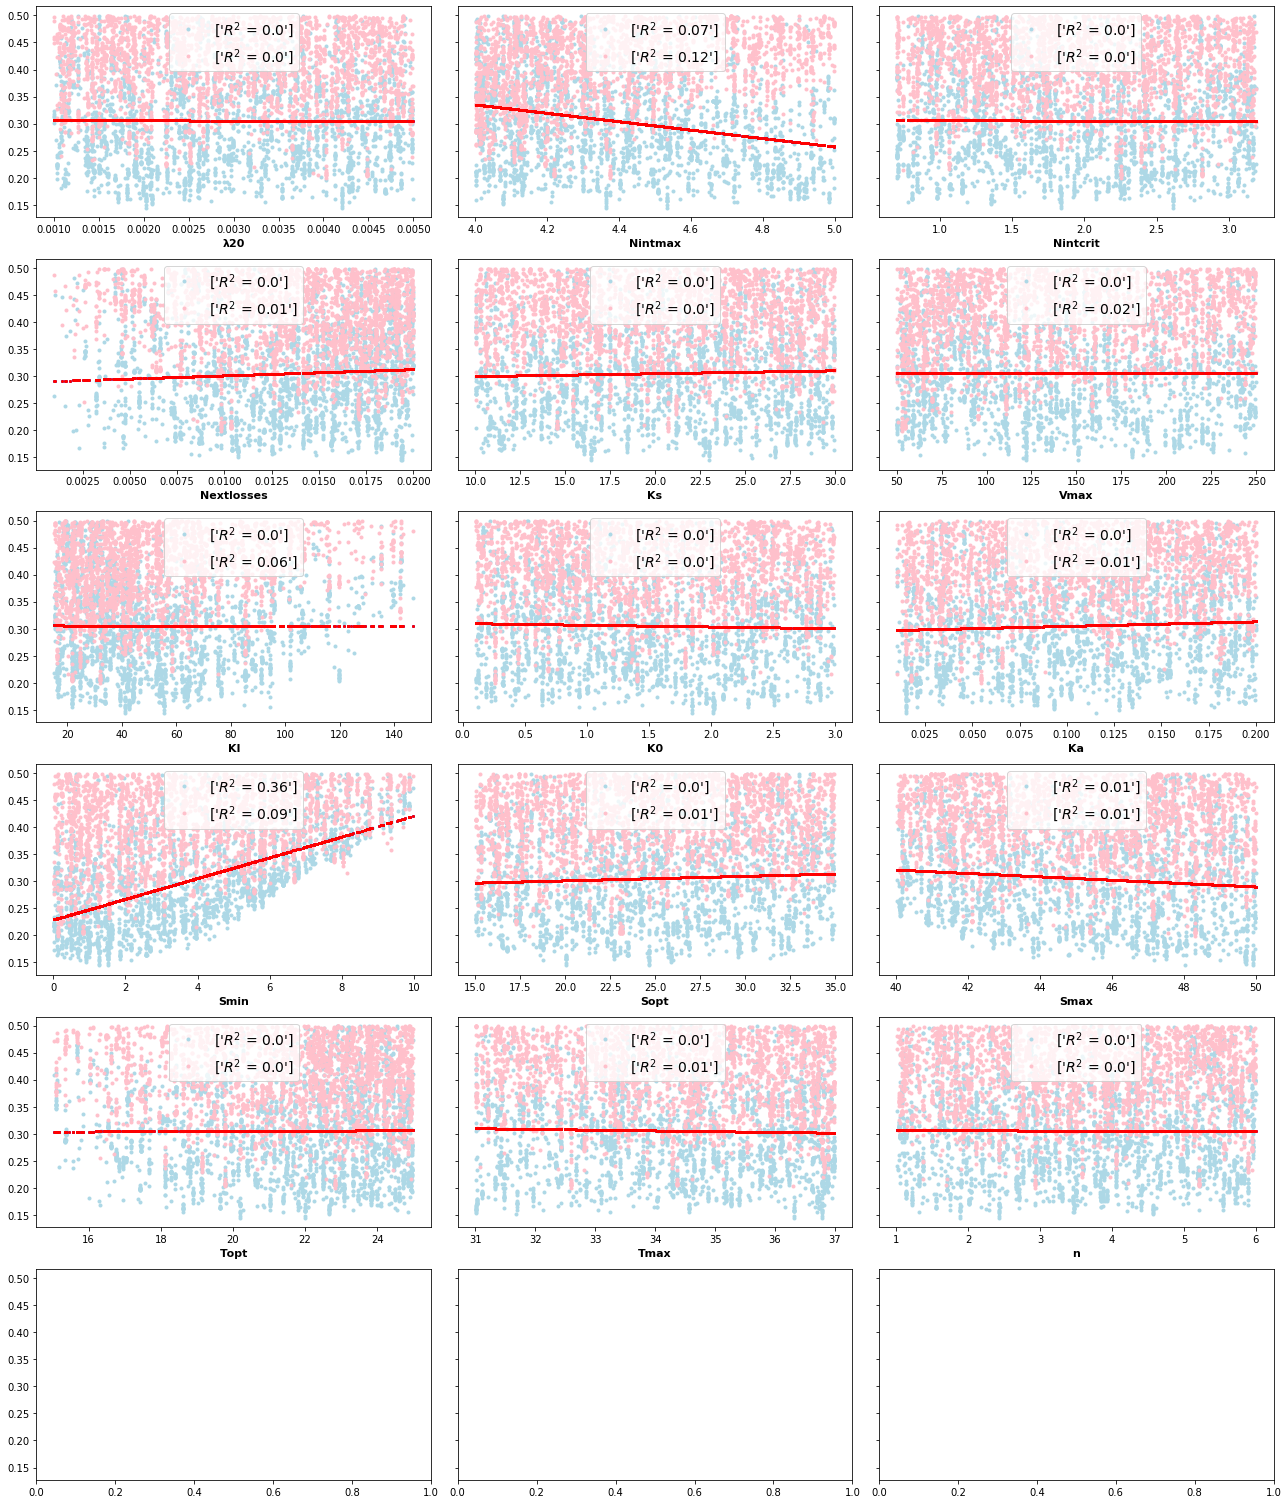

In [ ]:
Best_index = []
for i in range(len(Y1)):
    if (Y1[i] < 0.5) & (Y2[i] < 0.5):
        #print("parameters of index " + str(i) + " give error " + str(Y[i]) + "\n")
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y1[Best_index],'.',markersize=6,color = 'lightblue')
    ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient for m:
    mm, bb = np.polyfit(b[j], Y1[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'blue',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y1[Best_index])
    model = LinearRegression().fit(x, Y1[Best_index])
    r_sq = model.score(x, Y1[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    # regression line and coefficient for Nint:
    NN, cc = np.polyfit(b[j], Y2[Best_index], 1)
    ax0.flat[j].plot(b[j], mm*b[j] + bb,'.',color = 'red',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    modelN = LinearRegression()
    modelN.fit(x, Y2[Best_index])
    modelN = LinearRegression().fit(x, Y2[Best_index])
    r_sqN = modelN.score(x, Y2[Best_index])
    #print('KI coefficient of determination:', r_sq)
    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))],['$R^{2}$ = ' + str(round(r_sqN,2))]],fontsize = 14,loc = 'upper center')

plt.tight_layout()
plt.show()

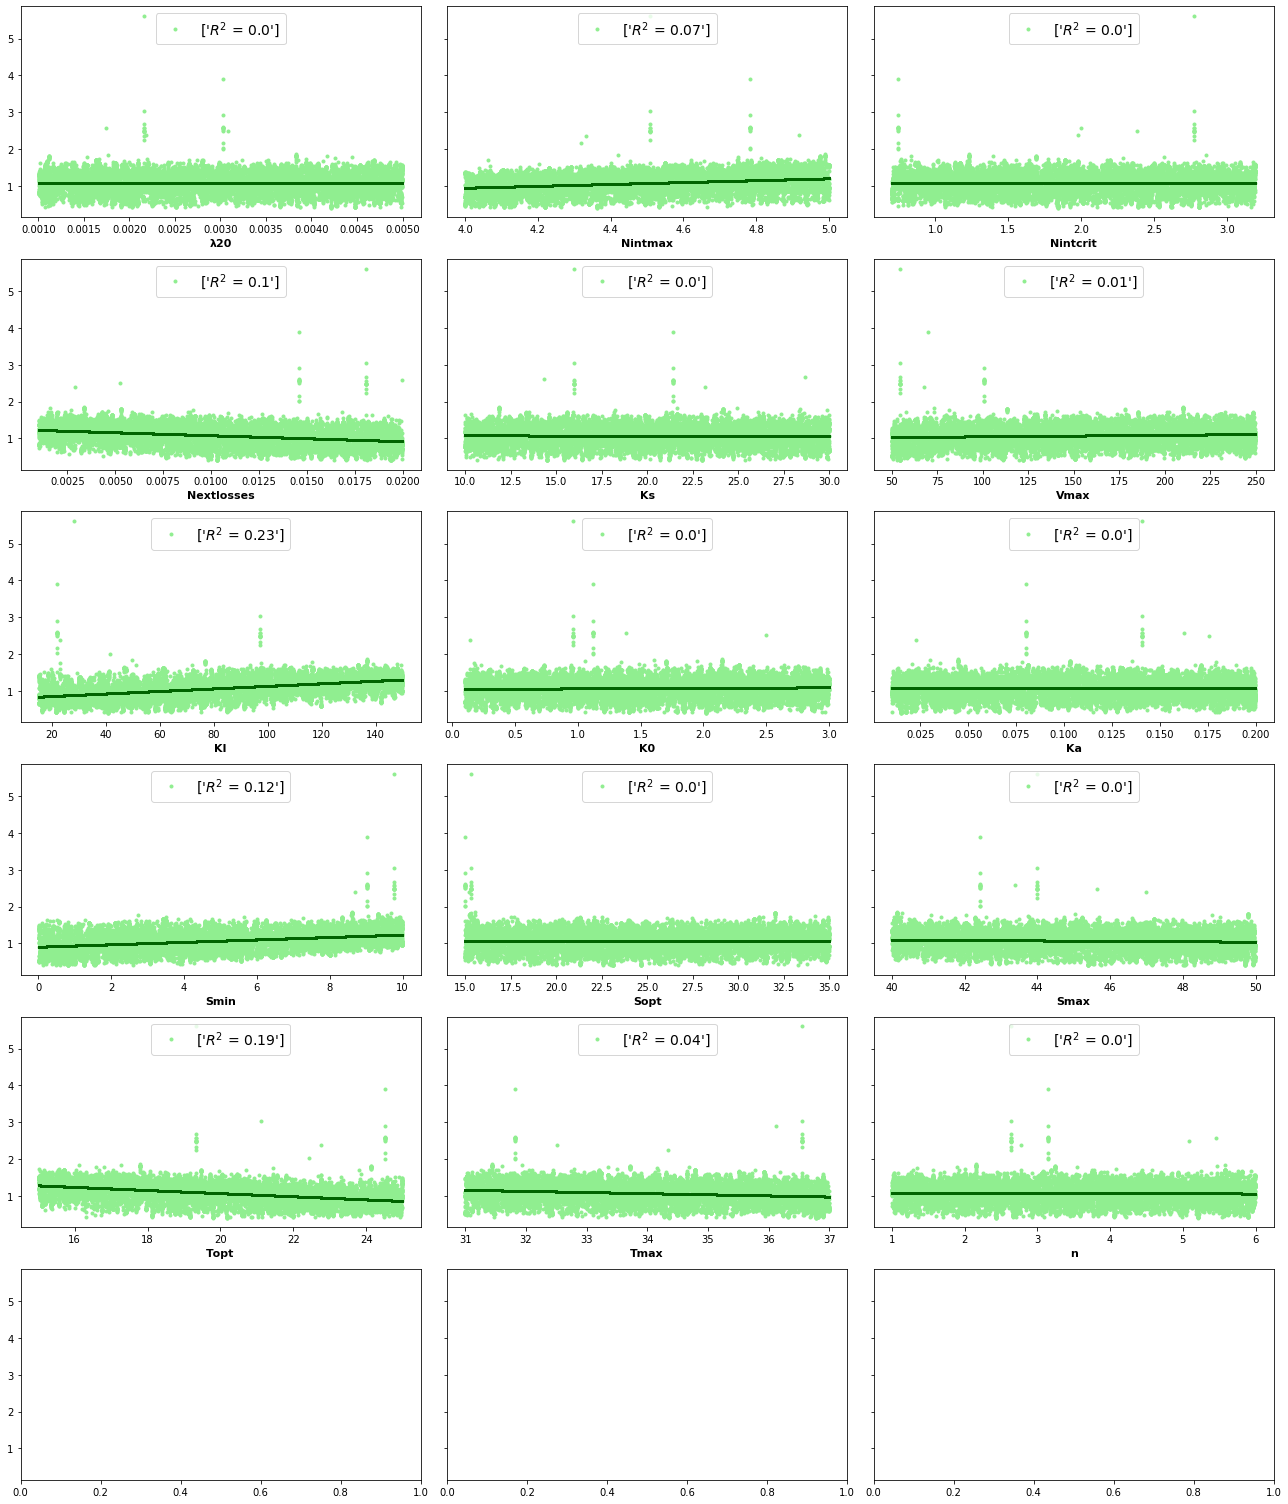

In [ ]:
Y3 = Y1+Y2
Best_index = []
for i in range(len(Y3)):
    Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sq = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Brine Combined Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

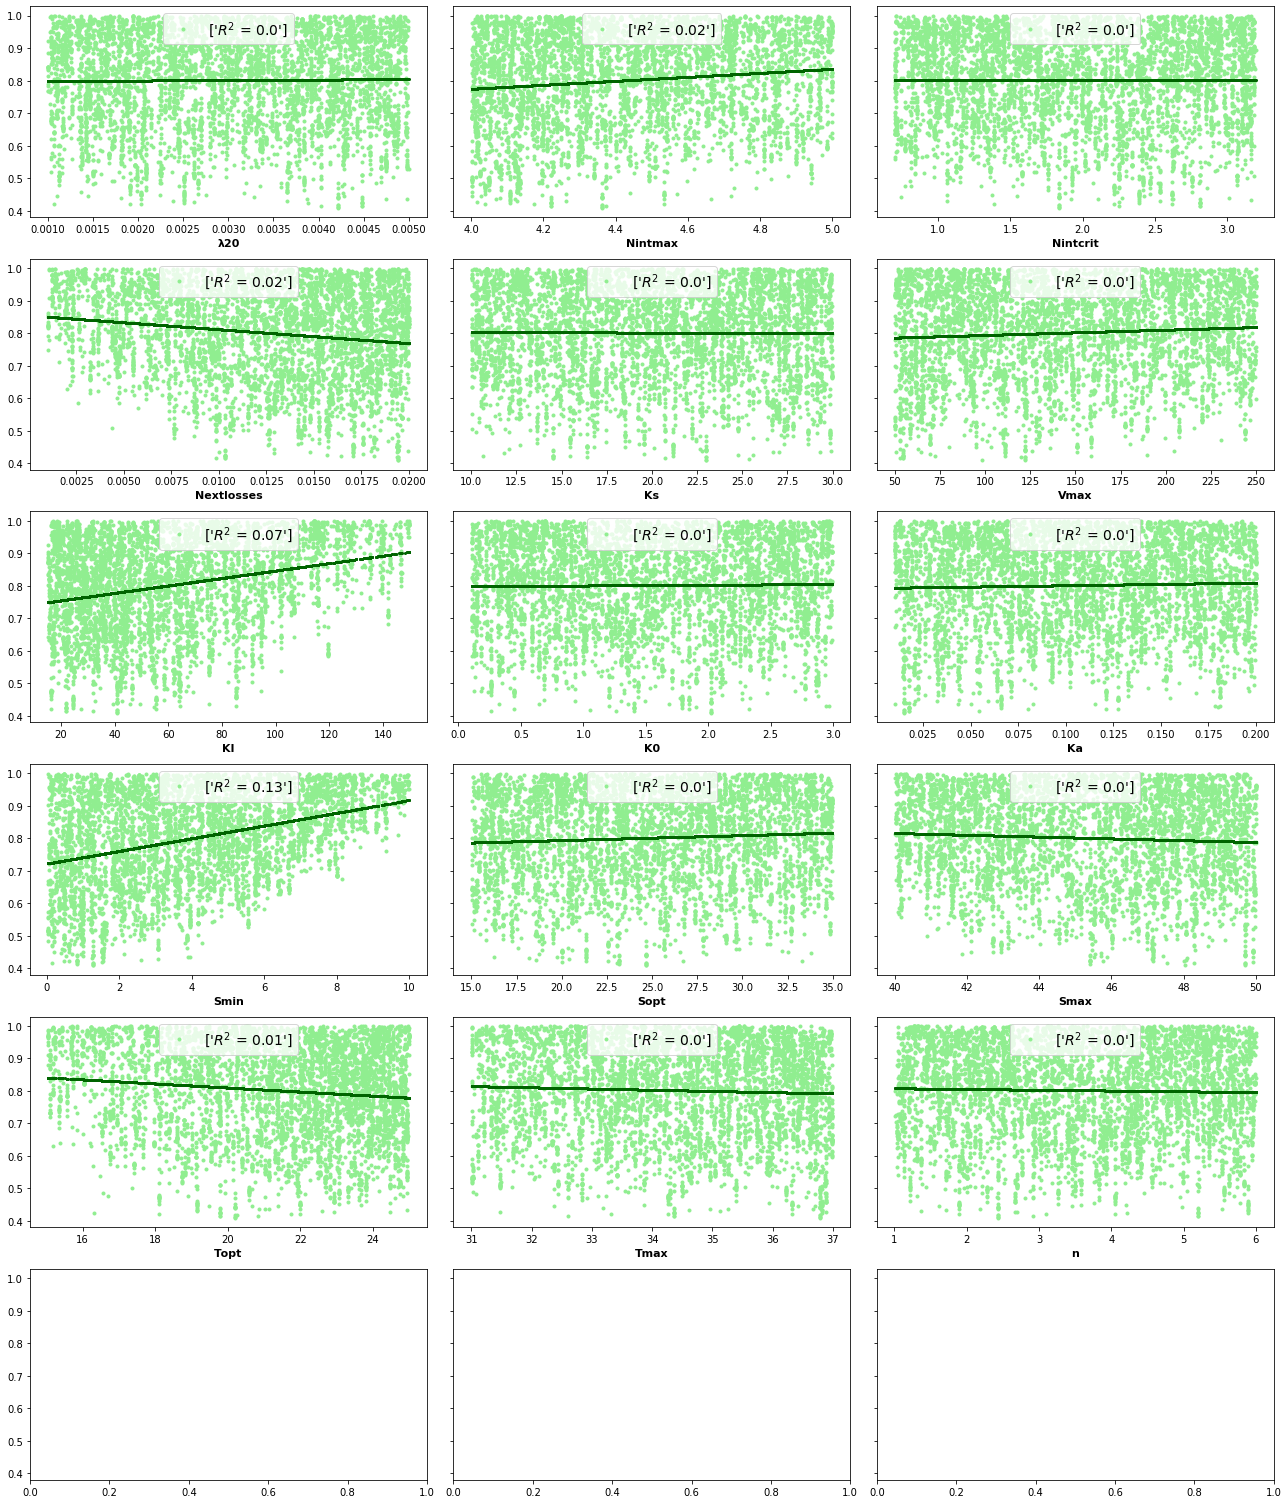

In [ ]:
Y3 = Y1+Y2
Best_index = []
for i in range(len(Y3)):
    if (Y3[i] < 1):
        Best_index.append(i)
        
b = param_values[Best_index].T

#print(b)
fig,ax0 = plt.subplots(5,3,figsize=(18,21),sharey=True)#,sharex=True)

for j in range(len(b)):
    ax0.flat[j].plot(b[j],Y3[Best_index],'.',markersize=6,color = 'lightgreen')
    #ax0.flat[j].plot(b[j],Y2[Best_index],'.',markersize=6,color = 'pink')
    ax0.flat[j].set_xlabel(str(problem['names'][j]),fontsize=11, weight="bold")
    #ax0.flat[j].set_ylabel('RMSRE',fontsize=12, weight="bold")
    #ax0.flat[j].set_xlim(problem['bounds'][0])
    
    # regression line and coefficient:
    MN, DD = np.polyfit(b[j], Y3[Best_index], 1)
    ax0.flat[j].plot(b[j], MN*b[j] + DD,'.',color = 'darkgreen',markersize=4)
    x = np.array(b[j]).reshape((-1, 1))
    model = LinearRegression()
    model.fit(x, Y3[Best_index])
    model = LinearRegression().fit(x, Y3[Best_index])
    r_sq = model.score(x, Y3[Best_index])
    #print('KI coefficient of determination:', r_sq)
    #ax0.flat[j].legend(['$R^{2}$ = ' + str(round(r_sq,2))])

    ax0.flat[j].legend([['$R^{2}$ = ' + str(round(r_sq,2))]],fontsize = 14,loc = 'upper center')


plt.tight_layout()
plt.show()

name = 'Brine Combined Reduced Error plots.png' 
    
fig.savefig(fname=name, dpi=600)

In [ ]:

minerrorm = min(Y1)
minerrorN = min(Y2)
minsumerrors = min(Y3)

merror_best = Y1[Y3.tolist().index(min(Y3))]
Nerror_best = Y2[Y3.tolist().index(min(Y3))]

indminerrorm = Y1.tolist().index(min(Y1))
indminerrorN = Y2.tolist().index(min(Y2))
BestParam_m = param_values[Y1.tolist().index(min(Y1))]
BestParam_N = param_values[Y2.tolist().index(min(Y2))]
BestParam = param_values[Y3.tolist().index(min(Y3))]

print('Minimum error for m: ' + str(minerrorm))
print('Minimum error for Nint: ' + str(minerrorN) + '\n')
print('Minimum sum of errors: ' + str(minsumerrors) + '\n')
print('Best error for m: ' + str(merror_best))
print('Best error for N: ' + str(Nerror_best))

for i in range(len(problem['names'])):
    print('Parameter: ' + str(problem['names'][i]) + ' Best values: ' + str(round(BestParam_m[i],3)) + ' , ' +str(round(BestParam_N[i],3)) + ' and: ' +str(round(BestParam[i],3))+'\n')

Minimum error for m: 0.145
Minimum error for Nint: 0.199

Minimum sum of errors: 0.41000000000000003

Best error for m: 0.157
Best error for N: 0.253
Parameter: λ20 Best values: 0.004 , 0.004 and: 0.004

Parameter: Nintmax Best values: 4.363 , 4.375 and: 4.363

Parameter: Nintcrit Best values: 1.839 , 2.254 and: 1.839

Parameter: Nextlosses Best values: 0.019 , 0.01 and: 0.019

Parameter: Ks Best values: 23.018 , 20.713 and: 23.018

Parameter: Vmax Best values: 122.168 , 52.832 and: 98.535

Parameter: KI Best values: 41.038 , 32.073 and: 41.038

Parameter: K0 Best values: 2.019 , 0.257 and: 2.019

Parameter: Ka Best values: 0.015 , 0.054 and: 0.015

Parameter: Smin Best values: 1.265 , 0.132 and: 1.265

Parameter: Sopt Best values: 24.658 , 17.979 and: 24.658

Parameter: Smax Best values: 48.042 , 48.296 and: 49.712

Parameter: Topt Best values: 20.19 , 22.827 and: 20.19

Parameter: Tmax Best values: 36.78 , 32.597 and: 36.78

Parameter: n Best values: 2.428 , 2.921 and: 2.428



In [ ]:
Y3.tolist().index(min(Y3))

4405

In [ ]:
param_values[Y3.tolist().index(min(Y3))]

array([4.20898438e-03, 4.36279297e+00, 1.83891602e+00, 1.93969727e-02,
       2.30175781e+01, 9.85351562e+01, 4.10375977e+01, 2.01870117e+00,
       1.51025391e-02, 1.26464844e+00, 2.46582031e+01, 4.97119141e+01,
       2.01904297e+01, 3.67802734e+01, 2.42822266e+00])

In [ ]:
X = param_values[Y3.tolist().index(min(Y3))].tolist()
X

#Best fit
#[0.0042089843750000005,4.36279296875, 1.838916015625, 0.01939697265625, 23.017578125, 98.53515625,41.03759765625,
# 2.018701171875, 0.0151025390625, 1.2646484375, 24.658203125, 49.7119140625, 20.1904296875, 36.7802734375, 2.42822265625]

[0.0042089843750000005,
 4.36279296875,
 1.838916015625,
 0.01939697265625,
 23.017578125,
 98.53515625,
 41.03759765625,
 2.018701171875,
 0.0151025390625,
 1.2646484375,
 24.658203125,
 49.7119140625,
 20.1904296875,
 36.7802734375,
 2.42822265625]

In [ ]:
miu = 0.03
#miu = X[0]
lossess20 = X[0]
Nintmax = X[1]
Nintcrit = X[2]
dNextoutdt = X[3]
Ks = X[4]
Vmax = X[5]
KI = X[6]
K0 = X[7]
Ka = X[8]
Smin = X[9]
Sopt = X[10]
Smax = X[11]
Topt = X[12]
Tmax = X[13]
n = X[14]

In [ ]:
miu

0.03

Run #1

j = 0
exp: 2
Real Nint is: 2
exp: 2
The modeled m is: 1.8[g FW/bottle], The measured m is 1.3[g FW/bottle]
The calculated error is: -0.385

The modeled Nint is: 3.43[% gN /g DW], The measured Nint is 3.12[% gN /g DW]
The calculated error is: -0.099

j = 1
exp: 3
Real Nint is: 3
exp: 3
The modeled m is: 1.8[g FW/bottle], The measured m is 2.1[g FW/bottle]
The calculated error is: 0.143

The modeled Nint is: 3.43[% gN /g DW], The measured Nint is 2.31[% gN /g DW]
The calculated error is: -0.485

j = 2
exp: 4
Real Nint is: 4
exp: 4
The modeled m is: 3.27[g FW/bottle], The measured m is 4[g FW/bottle]
The calculated error is: 0.183

The modeled Nint is: 3.51[% gN /g DW], The measured Nint is 2.47[% gN /g DW]
The calculated error is: -0.421

j = 3
exp: 5
Real Nint is: 5
exp: 5
The modeled m is: 3.27[g FW/bottle], The measured m is 3[g FW/bottle]
The calculated error is: -0.089

The modeled Nint is: 3.51[% gN /g DW], The measured Nint is 2.82[% gN /g DW]
The calculated error is: -0.2

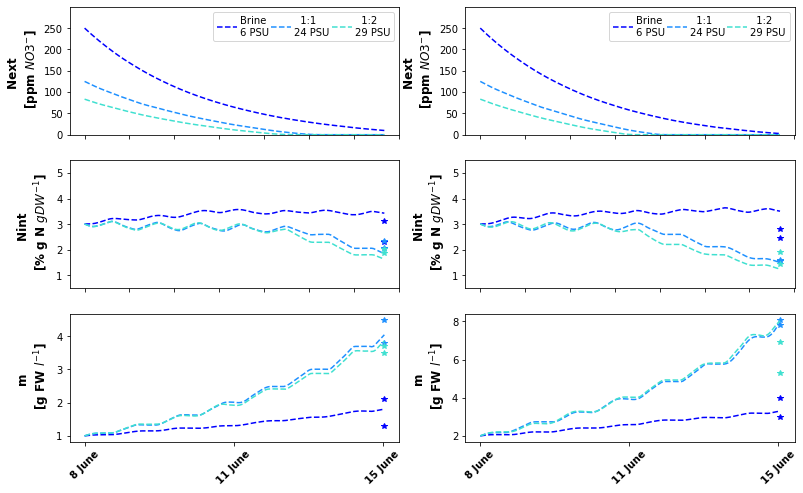

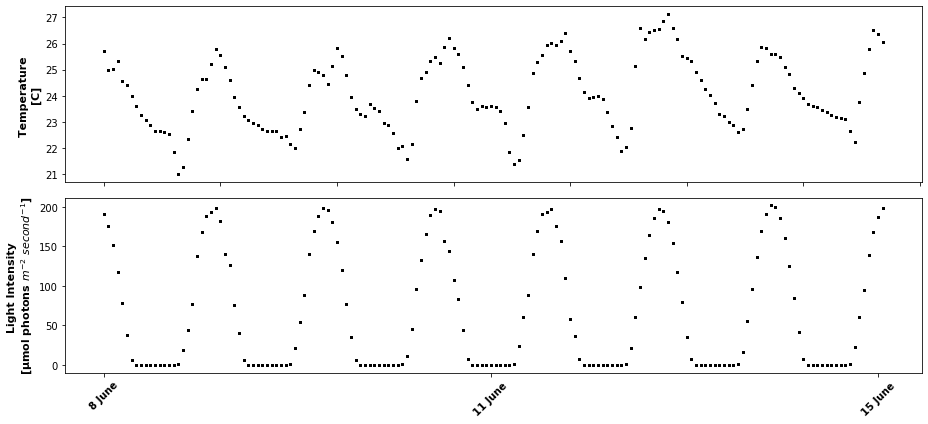

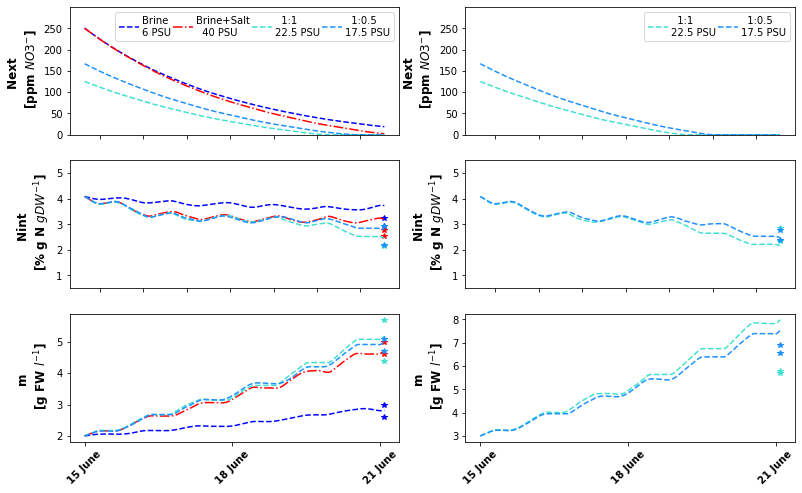

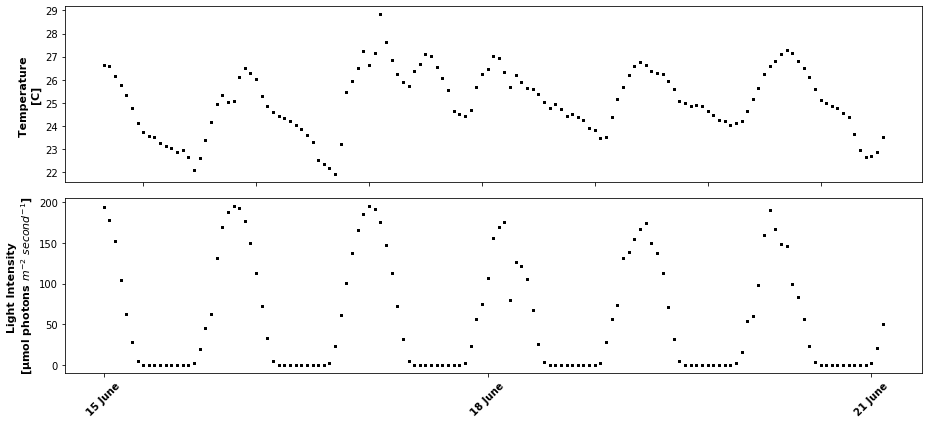

In [ ]:
#growth and N dynamics figures (based on IMS data) 

DATA = []
Errors, RMSRE_m = [], []
Errors, RMSRE_Nint = [], []
RMSRE_m_all, RMSRE_Nint_all = [],[]
returns = [1, 2]

# model simulation
for k in returns:
    Square_Errors_m = []
    Square_Errors_Nint = []
    
    print('Run #' + str(k) + '\n')
    
    fig, ax = plt.subplots(3,2,figsize=(13,8))
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    
    t0 = t0_all[k-1]
    t = list(range(t0,tf_all[k-1]))
    
    # T Data 
    TV_reduced = TV_average[k-1][0:len(t)]
    f1 = interpolate.interp1d(t, TV_reduced,kind = 'linear')
    
    # I Data
    IV_reduced = IV_average[k-1][0:len(t)]
    f0 = interpolate.interp1d(t, IV_reduced,kind = 'linear')
    
    xlabels = xlabels_all[k-1]
    
    for j in range(len(mi_all[k-1])):
        print('j = ' + str(j))
        
        # calculate and plot model results for each initial condition (runs only on odd numbers, to evoid dubble work)
        if j % 2 == 0:
            NEXT, NINT, M, T = [],[],[],[]

            line = '--'
            S = S_all[k-1][j]
            m0 = 0.15 * mi_all[k-1][j]
            Nint0 = Nint0_all[k-1][j]
            d = d_all[k-1][j]
            Next0 = Next00 / (1 + d)
            x0 = n_reactors*[Next0, Nint0, m0]
            
            if d == 0 and S < 10:
                color = 'blue'
            elif d == max(d_all[k-1]):
                color = 'turquoise'
            elif d != 0 and d != max(d_all[k-1]):
                color = 'dodgerblue'
            elif d == 0 and S > 10:
                color = 'red'
                line = '-.'
                
            # setup initial conditions identical for all reactors
            args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,S,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
                    teta,Sopt,Smin,Smax,f1,f0,dilution,n,umol_to_percent_DW,dNextoutdt)

            # solve the ODEs using the new syntax
            sol = solve_ivp(Bottles_IMS, [t[0], t[-1]], x0, args=args, t_eval = t)

            # take the solution of the state variables:
            NEXT.append(sol.y[0,:]/1000*62)
            NINT.append(sol.y[1,:])
            M.append(sol.y[2,:])

            T.append(sol.t)

            t = T[0]
            if mi_all[k-1][j] < max(mi_all[k-1]):
                r = 0
            else:
                r = 1
            l = l_all[k-1][r]

            ax[0,r].plot(t,NEXT[-1],linestyle = line,markersize=3.5,color=color)
            ax[0,r].set_ylim([0,Next00*1.2/1000*62])
            ax[1,r].plot(t,NINT[-1],linestyle = line,markersize=3.5,color=color)
            ax[1,r].set_ylim([0.5,5.5])
            ax[2,r].plot(t,M[-1]/0.15,linestyle = line,markersize=3.5,color=color)
            
            col = len(l)
            ax[0,r].legend(l,ncol=col,loc='upper right',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
        data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
        DATA.append(data)
        ax[2,r].plot(t[-1],mf_real[k-1][j],'*',markersize = 6,color=color)
        
        # Mark real Nint data as a star
        
        
        print('exp: ' + str(j+2))
        print('Real Nint is: ' + str(Nintf_exps[k-1][j]))
        if Nintf_exps[k-1][j] == j + 2:
            print('exp: ' + str(j + 2))
            ax[1,r].plot(t[-1],Nintf_real[k-1][j],'*',markersize = 6,color=color)
                
        ax[0,r].set_xticklabels([])
        ax[1,r].set_xticklabels([])
        ax[2,r].set_xticks(t[0:len(t):int(len(t)/2-1)])
        ax[2,r].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

        ax[0,r].set_ylabel('Next \n [ppm $NO3^{-}$]', fontsize=12, weight="bold")
        ax[1,r].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
        ax[2,r].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")
        
        plt.tight_layout()

        # plot I and T
        ax2[0].plot(t,TV_reduced,'.',markersize=3,color='black')
        ax2[1].plot(t,IV_reduced,'.',markersize=3,color='k')
            
        ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
        ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

        ax2[0].set_xticklabels([])
        ax2[1].set_xticklabels([])
        ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
        
        # calculate errors
        
        # m error
        
        final_m = round(M[-1][-1],2)
        #print(final_m)
        measured_m = round(mf_real[k-1][j],2)
        #print(measured_m)
        error_m = round((measured_m - final_m/0.15) / measured_m,3)
        square_error_m = error_m**2
        #print(square_error_m)
        
        Square_Errors_m.append(square_error_m)
        RMSRE_m_all.append((square_error_m)) # Square_Errors_m and RMSRE_m_all are the same in the mean while
        
        print('The modeled m is: ' + str(round(final_m/0.15,2)) + '[g FW/bottle], The measured m is ' + str(measured_m) + '[g FW/bottle]')
        print('The calculated error is: ' + str(error_m) + '\n')
        
        # Nint error
        
        final_Nint = round(NINT [-1][-1],2)
        
        if Nintf_exps[k-1][j] == j + 2: # ignoring samples without Nintf measurement
            measured_Nint = round(Nintf_real[k-1][j],2)
            error_Nint = round((measured_Nint - final_Nint) / measured_Nint,3)
            square_error_Nint = error_Nint**2
            #print(square_error_Nint)
            Square_Errors_Nint.append(square_error_Nint)
            RMSRE_Nint_all.append((square_error_Nint))
            
            print('The modeled Nint is: ' + str(round(final_Nint,2)) + '[% gN /g DW], The measured Nint is ' + str(measured_Nint) + '[% gN /g DW]')
            print('The calculated error is: ' + str(error_Nint) + '\n')
            
        plt.tight_layout()
    
    name = 'fig' + str(k) + 'a.png' 
    name2 = 'fig' + str(k) + 'b.png' 
    fig.savefig(fname=name, dpi=600)
    fig2.savefig(fname=name2, dpi=600)
    
    RMSRE_m.append((np.mean(Square_Errors_m))**0.5)
    

    #RMSRE_m_all.append((Square_Errors_m))
    print('for return ' + str(k) + ', RMSRE of m = ' + str(round(RMSRE_m[-1],2)) + '\n')
    
    RMSRE_Nint.append((np.mean(Square_Errors_Nint))**0.5)
    
    #print('for return ' + str(k) + ', RMSRE of Nint = ' + str(round(RMSRE_Nint[-1],2)) + '\n')

    Square_Errors_m,Square_Errors_Nint = [],[]

RMSRE_m_tot = (np.mean(RMSRE_m_all))**0.5
RMSRE_Nint_tot = (np.mean(RMSRE_Nint_all))**0.5
#print(RMSREm)
#print(RMSRENint)

print('The total errors are: RMSRE of m = ' + str(round(RMSRE_m_tot,3)) + ' RMSRE of Nint = ' + str(round(RMSRE_Nint_tot,3)) + '\n')


In [ ]:
print('The total errors are: RMSRE of m = ' + str(round(RMSRE_m_tot,3)) + ' RMSRE of Nint = ' + str(round(RMSRE_Nint_tot,3)) + '\n')

The total errors are: RMSRE of m = 0.157 RMSRE of Nint = 0.253



In [ ]:
miu = 0.03
#miu = X[0]
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 1.7 #1.8 #2.3 #2
dNextoutdt = 0.015 #0.01
Ks = 23 #15.5
Vmax = 50
KI = 16
K0 = 0.5 #2.4
Ka = 0.1 #0.085 #0.07 #0.12
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1

Run #1

j = 0
exp: 2
Real Nint is: 2
exp: 2
The modeled m is: 1.87[g FW/bottle], The measured m is 1.3[g FW/bottle]
The calculated error is: -0.436

The modeled Nint is: 3.45[% gN /g DW], The measured Nint is 3.12[% gN /g DW]
The calculated error is: -0.106

j = 1
exp: 3
Real Nint is: 3
exp: 3
The modeled m is: 1.87[g FW/bottle], The measured m is 2.1[g FW/bottle]
The calculated error is: 0.111

The modeled Nint is: 3.45[% gN /g DW], The measured Nint is 2.31[% gN /g DW]
The calculated error is: -0.494

j = 2
exp: 4
Real Nint is: 4
exp: 4
The modeled m is: 3.4[g FW/bottle], The measured m is 4[g FW/bottle]
The calculated error is: 0.15

The modeled Nint is: 3.47[% gN /g DW], The measured Nint is 2.47[% gN /g DW]
The calculated error is: -0.405

j = 3
exp: 5
Real Nint is: 5
exp: 5
The modeled m is: 3.4[g FW/bottle], The measured m is 3[g FW/bottle]
The calculated error is: -0.133

The modeled Nint is: 3.47[% gN /g DW], The measured Nint is 2.82[% gN /g DW]
The calculated error is: -0.23

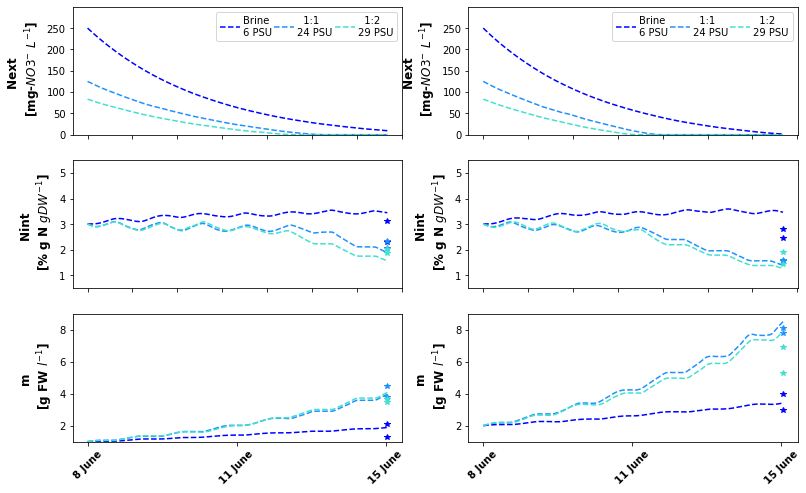

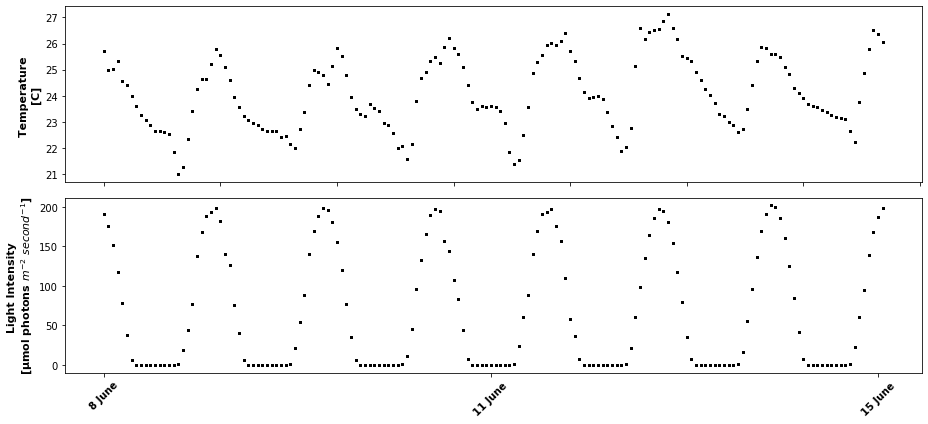

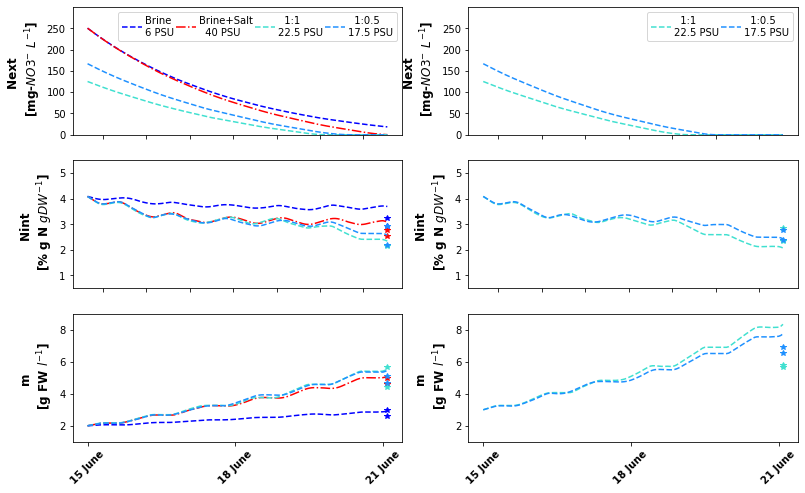

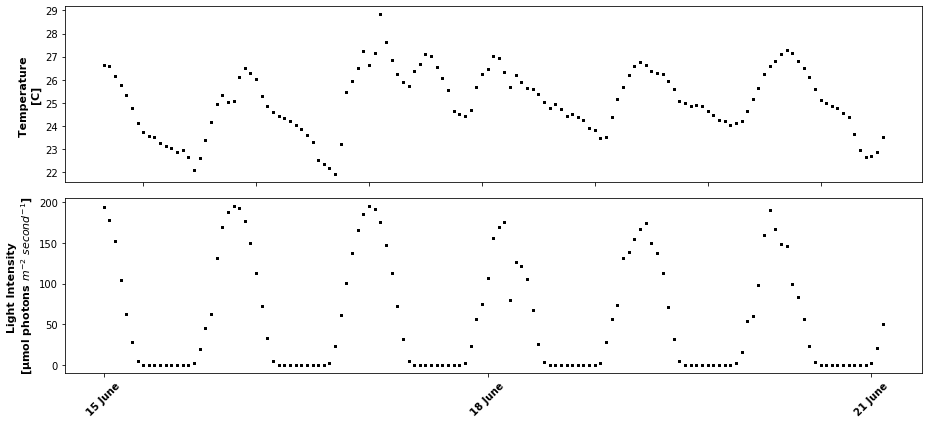

In [ ]:
#growth and N dynamics figures (based on IMS data) 

DATA = []
Errors, RMSRE_m = [], []
Errors, RMSRE_Nint = [], []
RMSRE_m_all, RMSRE_Nint_all = [],[]
returns = [1, 2]

# model simulation
for k in returns:
    Square_Errors_m = []
    Square_Errors_Nint = []
    
    print('Run #' + str(k) + '\n')
    
    fig, ax = plt.subplots(3,2,figsize=(13,8))
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    
    t0 = t0_all[k-1]
    t = list(range(t0,tf_all[k-1]))
    
    # T Data 
    TV_reduced = TV_average[k-1][0:len(t)]
    f1 = interpolate.interp1d(t, TV_reduced,kind = 'linear')
    
    # I Data
    IV_reduced = IV_average[k-1][0:len(t)]
    f0 = interpolate.interp1d(t, IV_reduced,kind = 'linear')
    
    xlabels = xlabels_all[k-1]
    
    for j in range(len(mi_all[k-1])):
        print('j = ' + str(j))
        
        # calculate and plot model results for each initial condition (runs only on odd numbers, to evoid dubble work)
        if j % 2 == 0:
            NEXT, NINT, M, T = [],[],[],[]

            line = '--'
            S = S_all[k-1][j]
            m0 = 0.15 * mi_all[k-1][j]
            Nint0 = Nint0_all[k-1][j]
            d = d_all[k-1][j]
            Next0 = Next00 / (1 + d)
            x0 = n_reactors*[Next0, Nint0, m0]
            
            if d == 0 and S < 10:
                color = 'blue'
            elif d == max(d_all[k-1]):
                color = 'turquoise'
            elif d != 0 and d != max(d_all[k-1]):
                color = 'dodgerblue'
            elif d == 0 and S > 10:
                color = 'red'
                line = '-.'
                
            # setup initial conditions identical for all reactors
            args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,S,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
                    teta,Sopt,Smin,Smax,f1,f0,dilution,n,umol_to_percent_DW,dNextoutdt)

            # solve the ODEs using the new syntax
            sol = solve_ivp(Bottles_IMS, [t[0], t[-1]], x0, args=args, t_eval = t)

            # take the solution of the state variables:
            NEXT.append(sol.y[0,:]/1000*62)
            NINT.append(sol.y[1,:])
            M.append(sol.y[2,:])

            T.append(sol.t)

            t = T[0]
            if mi_all[k-1][j] < max(mi_all[k-1]):
                r = 0
            else:
                r = 1
            l = l_all[k-1][r]

            ax[0,r].plot(t,NEXT[-1],linestyle = line,markersize=3.5,color=color)
            ax[0,r].set_ylim([0,Next00*1.2/1000*62])
            ax[1,r].plot(t,NINT[-1],linestyle = line,markersize=3.5,color=color)
            ax[1,r].set_ylim([0.5,5.5])
            ax[2,r].plot(t,M[-1]/0.15,linestyle = line,markersize=3.5,color=color)
            
            col = len(l)
            ax[0,r].legend(l,ncol=col,loc='upper right',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
        data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
        DATA.append(data)
        ax[2,r].plot(t[-1],mf_real[k-1][j],'*',markersize = 6,color=color)
        
        # Mark real Nint data as a star
        
        
        print('exp: ' + str(j+2))
        print('Real Nint is: ' + str(Nintf_exps[k-1][j]))
        if Nintf_exps[k-1][j] == j + 2:
            print('exp: ' + str(j + 2))
            ax[1,r].plot(t[-1],Nintf_real[k-1][j],'*',markersize = 6,color=color)
                
        ax[0,r].set_xticklabels([])
        ax[1,r].set_xticklabels([])
        ax[2,r].set_xticks(t[0:len(t):int(len(t)/2-1)])
        ax[2,r].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

        ax[0,r].set_ylabel('Next \n [mg-$NO3^{-}$ $L^{-1}$]', fontsize=12, weight="bold")
        ax[1,r].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
        ax[2,r].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")
        ax[2,r].set_ylim([1,9])
        
        
        plt.tight_layout()

        # plot I and T
        ax2[0].plot(t,TV_reduced,'.',markersize=3,color='black')
        ax2[1].plot(t,IV_reduced,'.',markersize=3,color='k')
            
        ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
        ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

        ax2[0].set_xticklabels([])
        ax2[1].set_xticklabels([])
        ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
        
        # calculate errors
        
        # m error
        
        final_m = round(M[-1][-1],2)
        #print(final_m)
        measured_m = round(mf_real[k-1][j],2)
        #print(measured_m)
        error_m = round((measured_m - final_m/0.15) / measured_m,3)
        square_error_m = error_m**2
        #print(square_error_m)
        
        Square_Errors_m.append(square_error_m)
        RMSRE_m_all.append((square_error_m)) # Square_Errors_m and RMSRE_m_all are the same in the mean while
        
        print('The modeled m is: ' + str(round(final_m/0.15,2)) + '[g FW/bottle], The measured m is ' + str(measured_m) + '[g FW/bottle]')
        print('The calculated error is: ' + str(error_m) + '\n')
        
        # Nint error
        
        final_Nint = round(NINT [-1][-1],2)
        
        if Nintf_exps[k-1][j] == j + 2: # ignoring samples without Nintf measurement
            measured_Nint = round(Nintf_real[k-1][j],2)
            error_Nint = round((measured_Nint - final_Nint) / measured_Nint,3)
            square_error_Nint = error_Nint**2
            #print(square_error_Nint)
            Square_Errors_Nint.append(square_error_Nint)
            RMSRE_Nint_all.append((square_error_Nint))
            
            print('The modeled Nint is: ' + str(round(final_Nint,2)) + '[% gN /g DW], The measured Nint is ' + str(measured_Nint) + '[% gN /g DW]')
            print('The calculated error is: ' + str(error_Nint) + '\n')
            
        plt.tight_layout()
    
    name = 'fig' + str(k) + 'a.png' 
    name2 = 'fig' + str(k) + 'b.png' 
    fig.savefig(fname=name, dpi=600)
    fig2.savefig(fname=name2, dpi=600)
    
    RMSRE_m.append((np.mean(Square_Errors_m))**0.5)
    

    #RMSRE_m_all.append((Square_Errors_m))
    print('for return ' + str(k) + ', RMSRE of m = ' + str(round(RMSRE_m[-1],2)) + '\n')
    
    RMSRE_Nint.append((np.mean(Square_Errors_Nint))**0.5)
    
    print('for return ' + str(k) + ', RMSRE of Nint = ' + str(round(RMSRE_Nint[-1],2)) + '\n')

    Square_Errors_m,Square_Errors_Nint = [],[]

RMSRE_m_tot = (np.mean(RMSRE_m_all))**0.5
RMSRE_Nint_tot = (np.mean(RMSRE_Nint_all))**0.5
#print(RMSREm)
#print(RMSRENint)

print('The total errors are: RMSRE of m = ' + str(round(RMSRE_m_tot,3)) + ' RMSRE of Nint = ' + str(round(RMSRE_Nint_tot,3)) + '\n')


In [ ]:
print('The total errors are: RMSRE of m = ' + str(round(RMSRE_m_tot,3)) + ' RMSRE of Nint = ' + str(round(RMSRE_Nint_tot,3)) + '\n')

The total errors are: RMSRE of m = 0.218 RMSRE of Nint = 0.212



In [ ]:
#0.193, 0.239
#0.19, 0.233
#0.201, 0.221
# 0.197, 0.224
#0.202,0.218
#0.198, 0.217
#0.216, 0.212